# Simple Asymetric Auto Encoder with and without AMD
* Number of epochs for training: 500 epochs
* Activation of the encoder: Sigmoid
* Encoder architecture: infoGAN
* Activation of the decoder: LeakyRELU (useless in case of Non-Negativity)


In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../SourceCode')
import bastien_utils
from shallowAE import ShallowAE
from sparseShallowAE import SparseShallowAE_KL, SparseShallowAE_L1, SparseShallowAE_KL_sum
from nonNegSparseShallowAE import Sparse_NonNeg_ShallowAE_KLsum_AsymDecay
from AsymAE_infoGAN.AsymAE_infoGAN import AsymAEinfoGAN
import datetime
import morphoMaths
import keras
import pandas as pd
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [6]:
FILE_PATH = "../"
x_test, y_test = bastien_utils.load_data(FILE_PATH, train=False, test=True, subsetTest=False)
x_small = x_test[:10]
x_small[2] = x_test[31]
print(x_small.shape)

(10, 28, 28, 1)


# 1. Simple

In [3]:
results = pd.read_csv("../Results/AsymAE_infoGAN/Simple/TestOutputs/18_08_30results")
results

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,5.994843,0.16681,0.882,100,0.006464,14.313341,14.412237,0.095573,0.006243,14.326369,14.424914,0.096033


Original images and reconstructions - Test MSE:  0.006463740646839142


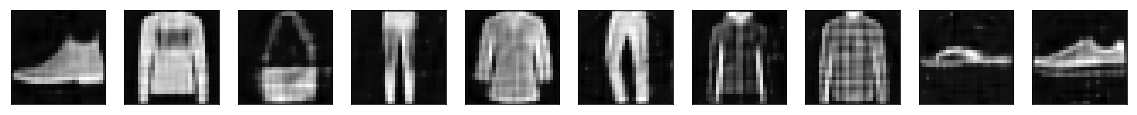

Histograms of encodings - Sparsity (Hoyer):  0.09557338058948517


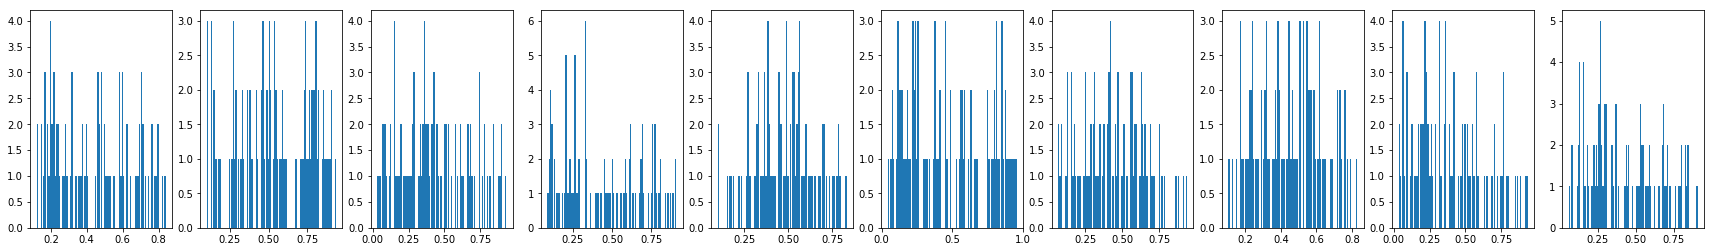

Atom images (weights of the encoder)


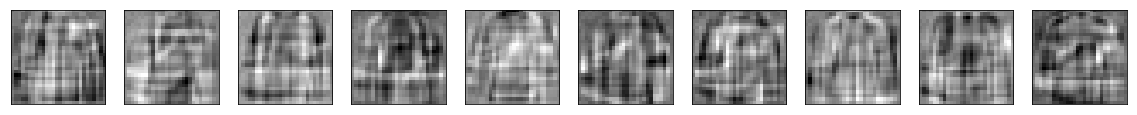

In [4]:
AE = AsymAEinfoGAN.load('18_08_30_dim100.h5')
print('Original images and reconstructions - Test MSE: ', results['test_error'][0])
AE.plot_reconstructions(x_small, plot_input=False)
print('Histograms of encodings - Sparsity (Hoyer): ', results['test_sparsity'][0])
AE.plot_histograms_of_the_encoding(x_small)
print('Atom images (weights of the encoder)')
AE.plot_atoms_decoder(nb_to_plot=10)

Dilatation of original images


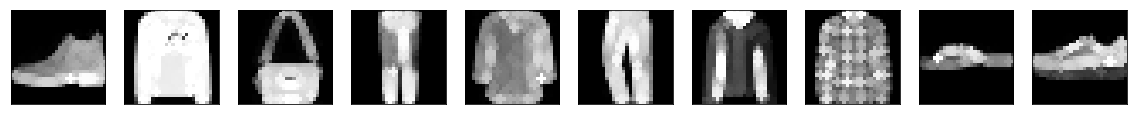

Dilatation of reconstructed images


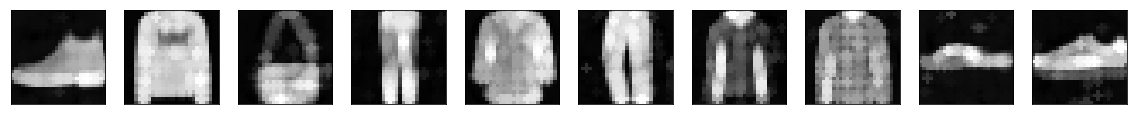

Max-approximation to dilatation
Max-approx error to original:  14.313341371154785  - Max-approx error to reconstruction:  14.412237312316895


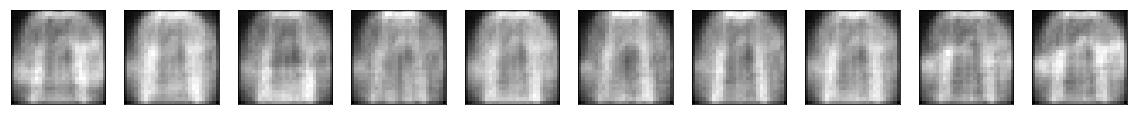

Dilatation of decoder weights


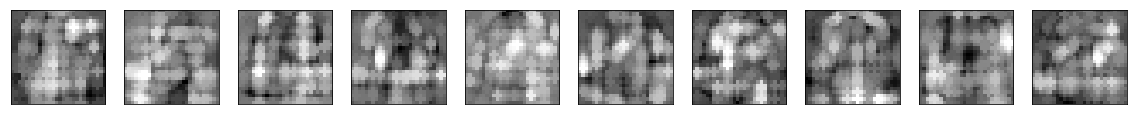

In [7]:
print('Dilatation of original images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
print('Dilatation of reconstructed images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=False, SE_scale=1)
print('Max-approximation to dilatation')
print('Max-approx error to original: ', results['test_max_approx_error_toOriginal_dilatation'][0], ' - Max-approx error to reconstruction: ', results['test_max_approx_error_toRec_dilatation'][0])
AE_dil.plot_reconstructions(x_small, plot_input=False)
print('Dilatation of decoder weights')
AE_dil.plot_atoms_decoder(nb_to_plot=10)

In [16]:
AE.max_approximation_error(x_test, morphoMaths.dilatation, apply_to_bias=False, SE_scale=1)

(13.683463877868652, 13.779756842041015)

In [7]:
x_train, _ = bastien_utils.load_data(FILE_PATH, train=True, test=False, subsetTest=False)
print("Sparsity measure (KL divergence) of train set: ", AE.KL_divergence(x_train, multiply_by_weight_penalty=False, sparsity_objective=0.01))
del x_train
print("Sparsity measure (KL divergence) of test set: ", AE.KL_divergence(x_test, multiply_by_weight_penalty=False, sparsity_objective=0.01))

Sparsity measure (KL divergence) of train set:  59.86934280395508
Sparsity measure (KL divergence) of test set:  59.81623840332031


In [7]:
AE.best_linearSVM_classification_score(x_test, y_test, nb_values_C=30)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.1s
[CV] C=0.01 ..........................................................
[CV] .

[CV] ............................ C=0.03290344562312668, total=   0.9s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.0s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.1s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.0s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.1s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.1s
[CV] C=0.04893900918477494 ...........................................
[CV] ............................ C=0.04893900918477494, total=   1.2s
[CV] C=0.04893900918477494 ...........................................
[CV] .

[CV] ............................ C=0.16102620275609392, total=   2.1s
[CV] C=0.16102620275609392 ...........................................
[CV] ............................ C=0.16102620275609392, total=   2.0s
[CV] C=0.16102620275609392 ...........................................
[CV] ............................ C=0.16102620275609392, total=   1.8s
[CV] C=0.2395026619987486 ............................................
[CV] ............................. C=0.2395026619987486, total=   1.9s
[CV] C=0.2395026619987486 ............................................
[CV] ............................. C=0.2395026619987486, total=   2.0s
[CV] C=0.2395026619987486 ............................................
[CV] ............................. C=0.2395026619987486, total=   2.0s
[CV] C=0.2395026619987486 ............................................
[CV] ............................. C=0.2395026619987486, total=   1.9s
[CV] C=0.2395026619987486 ............................................
[CV] .

[CV] ............................. C=0.7880462815669912, total=   2.2s
[CV] C=0.7880462815669912 ............................................
[CV] ............................. C=0.7880462815669912, total=   2.2s
[CV] C=0.7880462815669912 ............................................
[CV] ............................. C=0.7880462815669912, total=   2.2s
[CV] C=0.7880462815669912 ............................................
[CV] ............................. C=0.7880462815669912, total=   2.0s
[CV] C=0.7880462815669912 ............................................
[CV] ............................. C=0.7880462815669912, total=   1.9s
[CV] C=1.1721022975334805 ............................................
[CV] ............................. C=1.1721022975334805, total=   2.0s
[CV] C=1.1721022975334805 ............................................
[CV] ............................. C=1.1721022975334805, total=   2.1s
[CV] C=1.1721022975334805 ............................................
[CV] .

[CV] .............................. C=3.856620421163472, total=   3.4s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   3.2s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   3.7s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   4.2s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   4.1s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   3.3s
[CV] C=3.856620421163472 .............................................
[CV] .............................. C=3.856620421163472, total=   3.4s
[CV] C=5.736152510448681 .............................................
[CV] .

KeyboardInterrupt: 

# 2. With AMD, no Original Images

In [3]:
x_small_original = np.copy(x_small)
x_small = morphoMaths.AMD_in_one_array(x_small[:,:,:,0], levels=5, step=1, init_step=1, add_original_images=False)

/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for mult

In [4]:
x_test_original = np.copy(x_test)
x_test = morphoMaths.AMD_in_one_array(x_test[:,:,:,0], levels=5, step=1, init_step=1, add_original_images=False)

/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for mult

In [5]:
x_test.shape

(10000, 28, 28, 6)

In [7]:
results = pd.read_csv("../Results/AsymAE_infoGAN/SeveralChannels/WithAMD_NoOriginals/Simple/TestOutputs/18_09_06results")
results

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,5.994843,0.16681,0.881,100,0.006852,14.958295,14.937736,0.097551,0.006394,14.728599,14.778502,0.095713


Original images and reconstructions - Test MSE:  0.006851740843057633


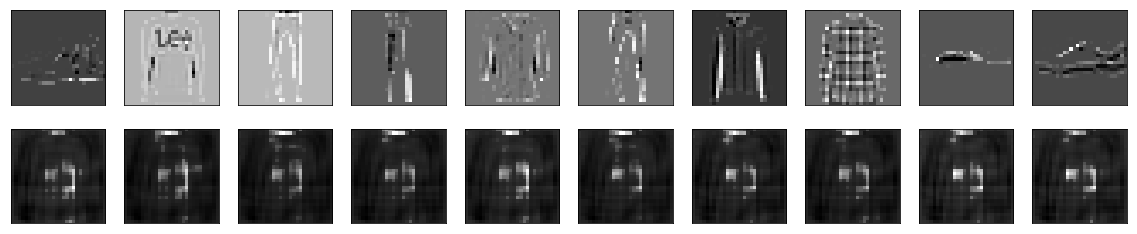

Histograms of encodings - Sparsity (Hoyer):  0.09755060076713562


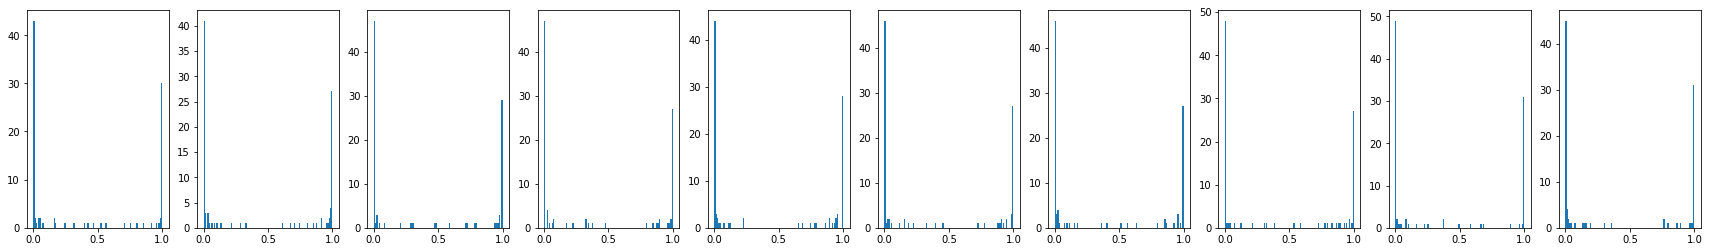

Atom images (weights of the encoder)


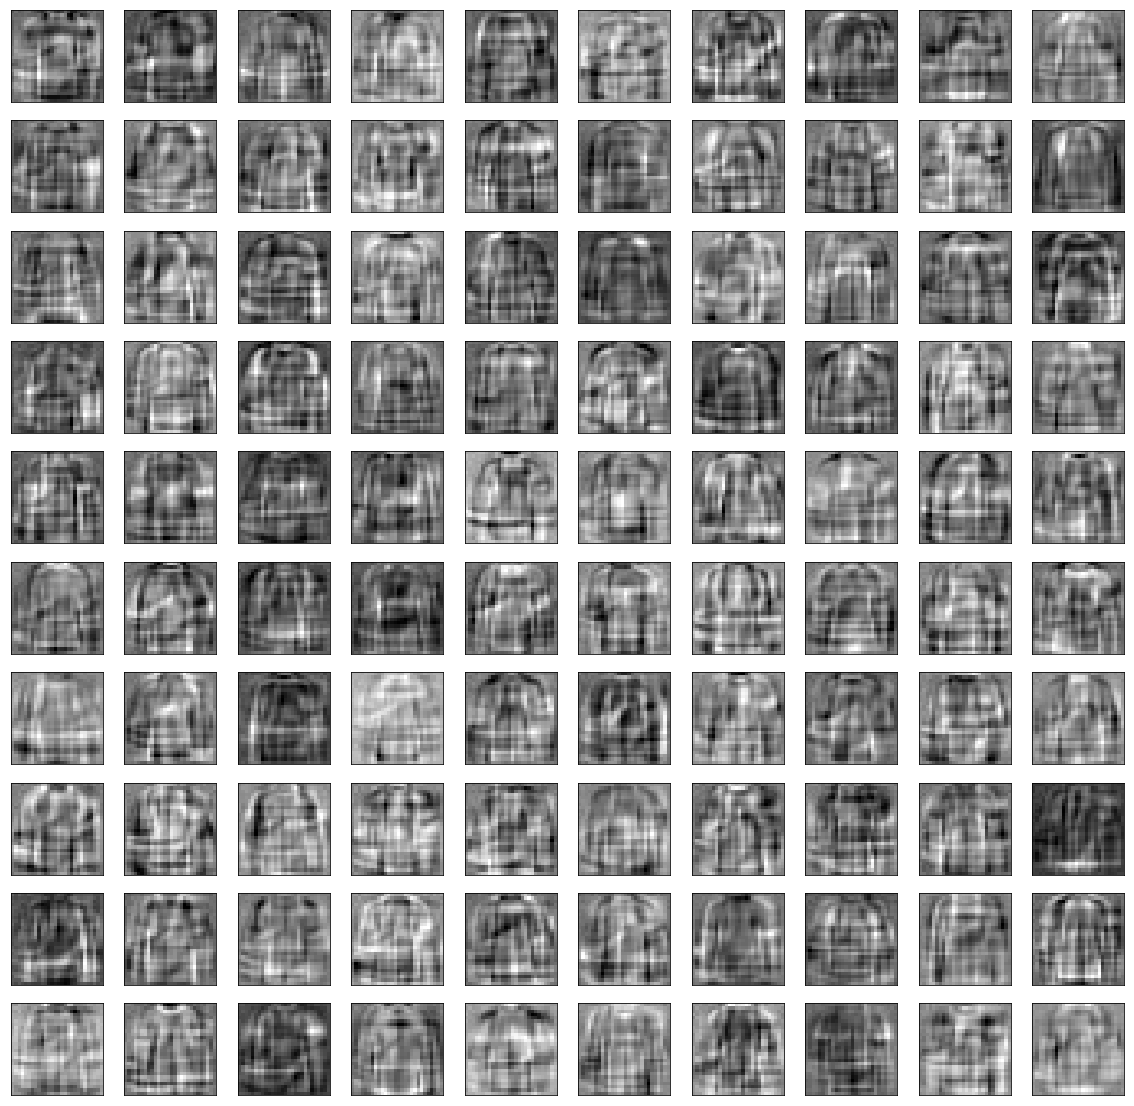

In [8]:
AE = AsymAEinfoGAN.load('18_09_06_dim100.h5', path_to_model_directory='../Results/AsymAE_infoGAN/SeveralChannels/WithAMD_NoOriginals/')
print('Original images and reconstructions - Test MSE: ', results['test_error'][0])
AE.plot_reconstructions(x_small)
print('Histograms of encodings - Sparsity (Hoyer): ', results['test_sparsity'][0])
AE.plot_histograms_of_the_encoding(x_small)
print('Atom images (weights of the encoder)')
AE.plot_atoms_decoder()

In [9]:
x_rec = AE.reconstruction(x_test)

In [ ]:
print('Dilatation of original images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
print('Dilatation of reconstructed images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=True, SE_scale=1)
print('Max-approximation to dilatation')
print('Max-approx error to original: ', results['test_max_approx_error_toOriginal_dilatation'][0], ' - Max-approx error to reconstruction: ', results['test_max_approx_error_toRec_dilatation'][0])
AE_dil.plot_reconstructions(x_small, plot_input=False)
print('Dilatation of decoder weights')
AE_dil.plot_atoms_decoder()

In [7]:
x_train, _ = bastien_utils.load_data(FILE_PATH, train=True, test=False, subsetTest=False)
print("Sparsity measure (KL divergence) of train set: ", AE.KL_divergence(x_train, multiply_by_weight_penalty=False, sparsity_objective=0.01))
del x_train
print("Sparsity measure (KL divergence) of test set: ", AE.KL_divergence(x_test, multiply_by_weight_penalty=False, sparsity_objective=0.01))

Sparsity measure (KL divergence) of train set:  59.86934280395508
Sparsity measure (KL divergence) of test set:  59.81623840332031
